# Module: ptychography

This module contains functions for performing ptychographic phase contrast imaging.

## Theory 

In ptychography [1,2], the projection approximation allows the 4-dimensional dataset $M(\vec{q},\vec{r})$ to be modeled 
as a multiplication of the electron wave function at the specimen plane and a complex-valued transmission function
of the sample. 

$M(\vec{r}',\vec{\rho}) = \left|\int a(\vec{r})T(\vec{r}-\vec{\rho})e^{2\pi i \vec{r} \cdot \vec{r}'}dr\right|^2,$

with $\vec{r}'$ being the diffraction space coordinate of the detector, and $\vec{\rho}$ being the real-space scanning
coordinate.

A Fourier transform along the scanning coordinate $\vec{x}$, and the assumption of a weak phase object $\mathcal{F}T(\vec{\rho}')=\delta(\vec{\rho}') + \Psi_s(\vec{\rho}')$
leads to the description [3]

$G(\vec{r}',\vec{\rho}') = |A(\vec{r}')|^2\delta(\vec{\rho}') + A(r')A^*(r'+\rho')\mathcal{F}T^*(-\rho')+ A^*(r')A(r'-\rho')\mathcal{F}T(\rho'),$

where $A(\vec{r}')$ is the complex-valued aperture function. 

This notebooks shows how to solve for the complex-valued object function T from an experimental dataset M.

### References:

* [1] Hoppe, W. Beugung im inhomogenen Primärstrahlwellenfeld. I. Prinzip einer Phasenmessung von Elektronenbeungungsinterferenzen. Acta Cryst. A 25, 495–501 (1969).

* [2] Rodenburg, J. M. & Bates, R. H. T. The Theory of Super-Resolution Electron Microscopy Via Wigner-Distribution Deconvolution. Philos. Trans. R. Soc. A Math. Phys. Eng. Sci. 339, 521–553 (1992).

* [3] Rodenburg, J. M., McCallum, B. C. & Nellist, P. D. Experimental tests on double-resolution coherent imaging via STEM. Ultramicroscopy 48, 304–314 (1993).

This notebook demos:
* Recontructing the phase with the weak phase approximation from a calibrated 4D STEM dataset


### Acknowledgements

This tutorial was written by Philipp Pelz (philipp.pelz@berkeley.edu) at Berkeley Lab.

The 4D-STEM dataset used here is from Philipp Pelz


### Version
Last updated on 2021-09-01 with py4DSTEM version 0.12.6.

---
# Part 0 - Download the datasets used in this tutorial <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (256 megabytes)
* [Filled Carbon Nanotube](https://drive.google.com/file/d/1bHv3u61Cr-y_GkdWHrJGh1lw2VKmt3UM/view?usp=sharing)

In [1]:
%load_ext autoreload
%autoreload 2
from py4DSTEM.io import download_file_from_google_drive
download_file_from_google_drive("1Y9mi1EdJwYK1hws5OEP9a8dNJ4cx7H3D", "/home/philipp/dl/carbon_nanotube_data_large.h5")

File Already Exists


In [2]:
# Initialization - import the needed packages.
# For this tutorial, we will need py4DSTEM, numpy, and h5py
import py4DSTEM
import numpy as np
import h5py    
from py4DSTEM.process.ptychography import weak_phase_reconstruction
from py4DSTEM.io.datastructure import Metadata


In [3]:
# Set the file paths for the input datasets.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change this path.
file_path_input = '/home/philipp/dl/carbon_nanotube_data_large.h5'
#file_path_input = 'C:/data/4DSTEM/carbon_nanotube_data.h5'
# file_path_input = '/media/cophus/DATA/4DSTEM/carbon_nanotube_data.h5'

In [4]:
# This dataset is stored in an HDF5 file, but is different from the current native py4DSTEM HDF5 / h5 format.

# So, our first step is to list all of the groups inside the .h5 file: (code adapted from issue #406 on the h5py github repo)
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print('%s %s' % (key, val))

f = h5py.File(file_path_input,'r')
f.visititems(print_attrs)

data


In [5]:
# The next step is to import this experiment as a py4DSTEM datacube.
# note that we are accessing a "dataset" inside various groups (groups are the HDF5 equivalent of directories)
dc = py4DSTEM.io.DataCube(data=f['data'][...].astype(np.float32))

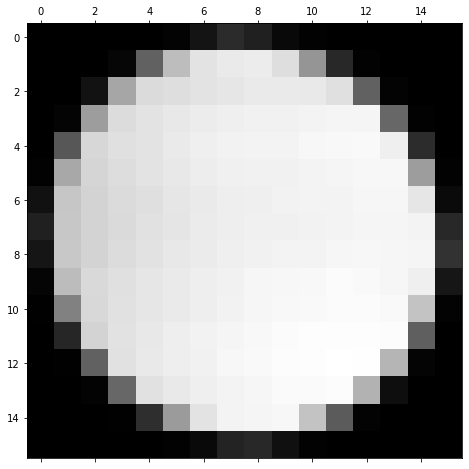

In [6]:
# Let's examine the mean diffraction space image, by taking the average over all probe positions:
diffraction_pattern_mean = np.mean(dc.data, axis=(0,1))
py4DSTEM.visualize.show(diffraction_pattern_mean)

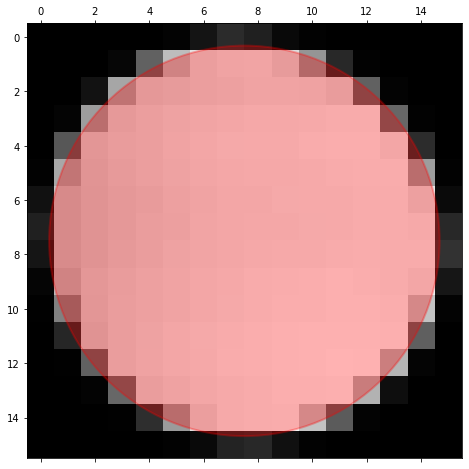

Estimated probe radius = 7.18 pixels


In [7]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(diffraction_pattern_mean)
qx0, qy0 = 7.5,7.5
# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(diffraction_pattern_mean, (qx0, qy0), probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [22]:
# Next, create a bright field (BF) virtual detector using the the center beam position, and expanding the radius slightly (+ 2 px).
expand_BF = 1.0
image_BF = py4DSTEM.process.virtualimage.get_virtualimage(dc, ((qx0, qy0), probe_semiangle + expand_BF))

100%|██████████| 262144/262144 [00:01<00:00, 145284.79it/s]


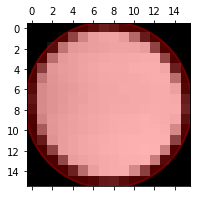

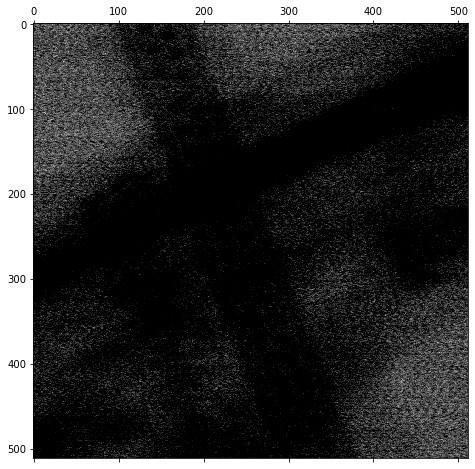

In [23]:
# Show the BF image, next to the virtual detector we have used
py4DSTEM.visualize.show_circles(diffraction_pattern_mean, (qx0, qy0), probe_semiangle + expand_BF, figsize=(3,3))
py4DSTEM.visualize.show(image_BF, clipvals='std', min=0.1, max=3.5)

### set acceleration voltage in eV, convergence angle and real-space pixel size

In [24]:
E = 80e3
lam = py4DSTEM.process.utils.electron_wavelength_angstrom(E)
alpha_rad = 25e-3
dx = 0.3162

rmax = dc.data.shape[-1] // 2
r = probe_semiangle
alpha_max = rmax / r * alpha_rad
r_min = lam / (2*alpha_max)
k_max = 1/2/r_min

m = Metadata()
m.set_beam_energy(80e3)
m.set_R_pixel_size([0.3162,0.3162])
m.set_R_pixel_size_units('A')
m.set_Q_pixel_size_units('A^-1')
m.set_QR_rotation_units('deg')
m.set_Q_pixel_size([k_max,k_max])
m.set_convergence_semiangle_mrad(alpha_rad*1e3)

print(f"alpha_max = {alpha_max*1e3} mrad")
print(f"k_max     = {k_max}*A^-1")
print(f"r_min     = {k_max}*A")

dc.metadata = m

alpha_max = 27.84295808357927 mrad
k_max     = 0.6667829089767426*A^-1
r_min     = 0.6667829089767426*A


# Part 2 - determine STEM rotation <a class="anchor" id="part_02"></a>


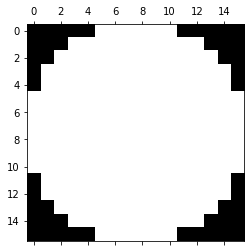

In [25]:
# Generate the circular mask, using the same coordinates determined above.
mask = py4DSTEM.process.utils.make_circular_mask(shape = (dc.Q_Nx,dc.Q_Ny),
                                               qxy0 = (qx0, qy0),
                                               radius = probe_semiangle + expand_BF)
    
# Plot the mask
py4DSTEM.visualize.show(mask, figsize=(4,4))

In [26]:
# Calculate the center of mass for all probe positions
m = dc.data.sum((2,3)) == 0
dc.data[m] = 1e-3
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(dc, mask=mask)

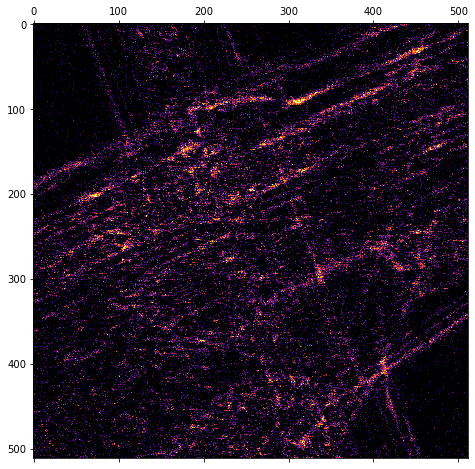

In [27]:
# Plot the gradient magnitude, from -1 to +5 standard deviations
py4DSTEM.visualize.show(np.sqrt(CoMx**2 + CoMy**2),
                       cmap='inferno',
                       clipvals='std',
                       min=0.5,
                       max=4.5)

In [28]:
# Use one of the py4DSTEM algorithms to check for:
# 1 - rotation offset between real and diffraction space coordinates
# 2 - a flip / transpose of the two spaces
# theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_maxcontrast(CoMx, CoMy, 360)

In [29]:
# Solve for minimum rotation from (-pi,pi) radian range
# theta = np.mod(theta + np.pi, 2*np.pi) - np.pi
theta_deg = -7.0195#theta*180/np.pi

# Print the results
# print('Image flip detected =', flip);
print('Best fit rotation = ', '%.4f' % theta_deg, 'degrees')

dc.metadata.set_QR_rotation(theta_deg)

Best fit rotation =  -7.0195 degrees


In [ ]:
im_ssb, im_ssb_left_sideband, im_ssb_right_sideband = weak_phase_reconstruction(dc, verbose=True, use_cuda=True)

E               = 80000.0             eV
λ               = 4.2   pm
dR              = [0.3162, 0.3162]             Å
dK              = [0.6667829089767426, 0.6667829089767426]           Å
scan       size = [512, 512]
detector   size = [16, 16]


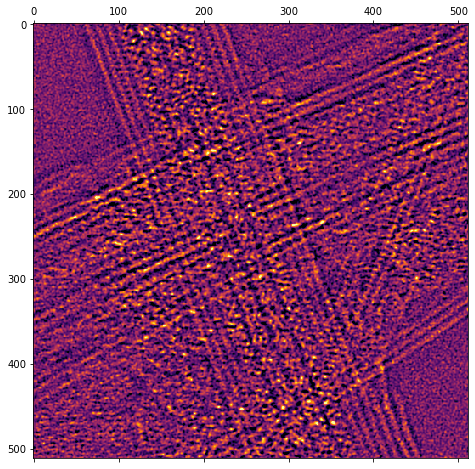

In [17]:
# Plot the output phase image
py4DSTEM.visualize.show(np.angle(im_ssb), cmap='inferno', clipvals='std', min=-2, max=4)